In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import scanpy as sc
import anndata as ad
import multigrate as mtg
from random import shuffle
from scipy import sparse
from matplotlib import pyplot as plt
import gdown

# Load the dataset

In [12]:
gdown.download(
    'https://drive.google.com/uc?id=1mXikpKDZ6Nqh42kDHHbwVeMJWc1V9mdB',
    'gayoso2020-expressions.h5ad'
)

Downloading...
From: https://drive.google.com/uc?id=1mXikpKDZ6Nqh42kDHHbwVeMJWc1V9mdB
To: /mnt/home/icb/anastasia.litinetskaya/multigrate/example/gayoso2020-expressions.h5ad
204MB [00:01, 106MB/s]  


'gayoso2020-expressions.h5ad'

In [13]:
scrna = sc.read('gayoso2020-expressions.h5ad')
scrna

AnnData object with n_obs × n_vars = 30293 × 4000
    obs: 'batch_indices', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'tissue', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_colors', 'cell_types_colors', 'neighbors', 'pca', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'count'
    obsp: 'connectivities', 'distances'

In [14]:
gdown.download(
    'https://drive.google.com/uc?id=1Y4wyzhaXrmW1anoByA5clmzrY6OurL4R',
    'gayoso2020-proteins.h5ad'
)

Downloading...
From: https://drive.google.com/uc?id=1Y4wyzhaXrmW1anoByA5clmzrY6OurL4R
To: /mnt/home/icb/anastasia.litinetskaya/multigrate/example/gayoso2020-proteins.h5ad
57.4MB [00:00, 119MB/s] 


'gayoso2020-proteins.h5ad'

In [15]:
cite = sc.read('gayoso2020-proteins.h5ad')
cite

AnnData object with n_obs × n_vars = 30293 × 110
    obs: 'batch_indices', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'tissue', 'batch'
    var: 'n_cells'
    uns: 'batch_colors', 'cell_types_colors', 'neighbors', 'pca', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'count'
    obsp: 'connectivities', 'distances'

In [16]:
scrna.obs.rename(columns={'cell_types': 'cell_type'}, inplace=True)
cite.obs.rename(columns={'cell_types': 'cell_type'}, inplace=True)

In [17]:
scrna1 = scrna[scrna.obs['batch_indices'] == 0]
scrna2 = scrna[scrna.obs['batch_indices'] == 1]

In [18]:
cite1 = cite[cite.obs['batch_indices'] == 0]
cite2 = cite[cite.obs['batch_indices'] == 1]

## Configure and train the model

In [26]:
model = mtg.models.MultiVAE(
    adatas=[[scrna1, scrna2], [cite1, cite2]],
    names=[['RNA-batch1', 'RNA-batch2'], ['ADT-batch1', 'ADT-batch2']],
    pair_groups=[[0, 1], [0, 1]],
    condition=False,
    z_dim=20,
    h_dim=64,
    hiddens=[[], []],
    output_activations=['linear', 'leakyrelu'],
    losses=['nb', 'mse'],
    layers=[['count', 'count'], [None, None]],
    shared_hiddens=[],
    adver_hiddens=[],
    recon_coef=1,
    kl_coef=1e-5,
    integ_coef=1e-2,
    cycle_coef=0,
    adversarial=False,
    dropout=0.2,
)

In [27]:
model.train(
    n_iters=10000,
    batch_size=256,
    lr=3e-4,
    val_split=0.1,
    adv_iters=0,
    kl_anneal_iters=3500,
    validate_every=1000,
    verbose=1
)

 |████████████████████| 100.0% iter=10000/10000, time=30.34(s), loss=0.4331, recon=0.4320, kl=91.2244, integ=0.0183, cycle=0.0000, val_loss=0.4002, val_recon=0.3990, val_kl=84.0631, val_integ=0.0321, val_cycle=0.0000

## Plot training history

In [28]:
model.history

,iteration,train_loss,train_recon,train_kl,train_integ,train_cycle,val_loss,val_recon,val_kl,val_integ,val_cycle
0,1000,0.577683,0.577500,32.847467,0.012211,0.0,0.468153,0.467877,38.408360,0.016649,0
1,2000,0.474908,0.474545,48.596967,0.013477,0.0,0.422094,0.421608,55.105748,0.017095,0
2,3000,0.456548,0.455908,67.485433,0.013575,0.0,0.417579,0.416814,68.620457,0.017686,0
3,4000,0.447819,0.446917,77.158353,0.014651,0.0,0.414941,0.413980,77.359855,0.018721,0
4,5000,0.443907,0.442926,83.525999,0.014612,0.0,0.412476,0.411440,82.778826,0.020824,0
5,6000,0.442985,0.441940,87.295494,0.017198,0.0,0.409662,0.408535,86.454328,0.026214,0
6,7000,0.440454,0.439352,90.838329,0.019344,0.0,0.406027,0.404866,88.013576,0.028108,0
7,8000,0.437929,0.436823,92.010530,0.018590,0.0,0.403144,0.401997,87.682722,0.026982,0
8,9000,0.436873,0.435769,91.315952,0.019102,0.0,0.401903,0.400748,87.536342,0.028040,0
9,9999,0.433141,0.432046,91.224391,0.018281,0.0,0.400198,0.399036,84.063058,0.032098,0


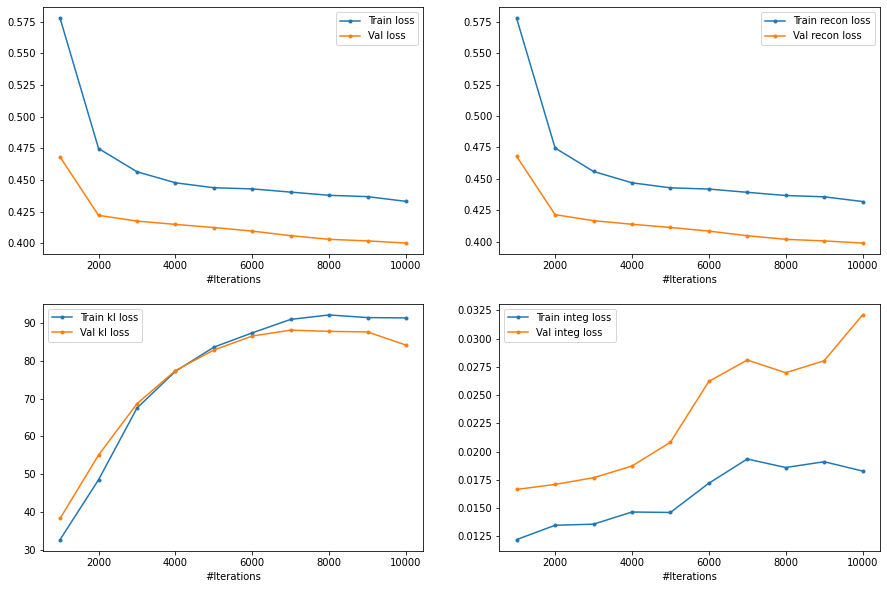

In [29]:
plt.figure(figsize=(15, 10));
plt.subplot(221);
plt.plot(model.history['iteration'], model.history['train_loss'], '.-', label='Train loss');
plt.plot(model.history['iteration'], model.history['val_loss'], '.-', label='Val loss');
plt.xlabel('#Iterations');
plt.legend();

plt.subplot(222);
plt.plot(model.history['iteration'], model.history['train_recon'], '.-', label='Train recon loss');
plt.plot(model.history['iteration'], model.history['val_recon'], '.-', label='Val recon loss');
plt.xlabel('#Iterations');
plt.legend();

plt.subplot(223);
plt.plot(model.history['iteration'], model.history['train_kl'], '.-', label='Train kl loss');
plt.plot(model.history['iteration'], model.history['val_kl'], '.-', label='Val kl loss');
plt.xlabel('#Iterations');
plt.legend();

plt.subplot(224);
plt.plot(model.history['iteration'], model.history['train_integ'], '.-', label='Train integ loss');
plt.plot(model.history['iteration'], model.history['val_integ'], '.-', label='Val integ loss');
plt.xlabel('#Iterations');
plt.legend();

## Recover and visualize the latent space

In [30]:
z = model.predict(
    adatas=[[scrna1, scrna2], [cite1, cite2]],
    names=[['RNA-batch1', 'RNA-batch2'], ['ADT-batch1', 'ADT-batch2']],
    pair_groups=[[0, 1], [0, 1]],
    batch_size=256,
)
z

AnnData object with n_obs × n_vars = 30293 × 20
    obs: 'modality', 'barcode', 'cell_type', 'batch'

In [31]:
sc.pp.neighbors(z)
sc.tl.umap(z)

... storing 'modality' as categorical
... storing 'cell_type' as categorical


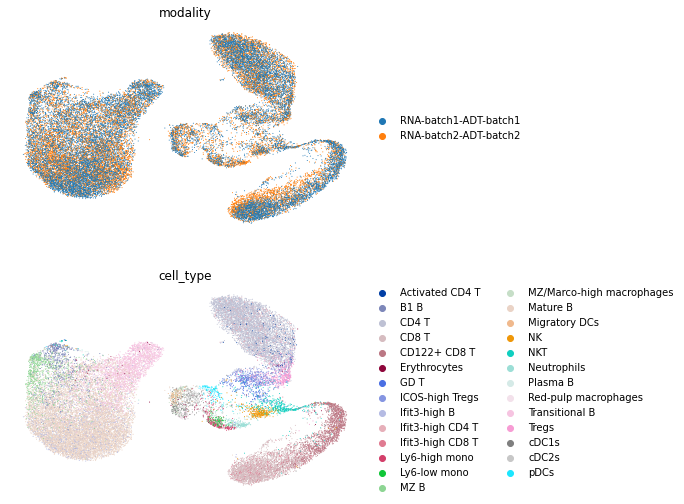

In [32]:
sc.pl.umap(z, color=['modality', 'cell_type'], ncols=1, frameon=False)

In [33]:
z.write('../data/integrated/multigrate/gayoso-multigrate.h5ad')

## Remove old files

In [34]:
!rm 'gayoso2020-proteins.h5ad'
!rm 'gayoso2020-expressions.h5ad'